In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from sklearn.metrics import confusion_matrix
from pathlib import Path
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping
from keras import regularizers
from google.colab import drive
TRAIN_PATH = "archive/traffic_Data/DATA"
TEST_PATH = "archive/traffic_Data/TEST"
Augmented_list = [1, 8, 9, 10, 13, 15, 18, 19, 20, 21, 22, 23, 25, 27, 29, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 57]
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
BATCH_SIZE = 64
DATA_DIST = {"00": 0, "01": 0, "02": 0, "03": 0, "04": 0, "05": 0, "06": 0, "07": 0, "08": 0, "09": 0, "10": 0, "11": 0, "12": 0, "13": 0, "14": 0, "15": 0, "16": 0, "17": 0,
             "18": 0, "19": 0, "20": 0, "21": 0, "22": 0, "23": 0, "24": 0, "25": 0, "26": 0, "27": 0, "28": 0, "29": 0, "30": 0, "31": 0, "32": 0, "33": 0, "34": 0, "35": 0,
             "36": 0, "37": 0, "38": 0, "39": 0, "40": 0, "41": 0, "42": 0, "43": 0, "44": 0, "45": 0, "46": 0, "47": 0, "48": 0, "49": 0, "50": 0, "51": 0, "52": 0, "53": 0,
             "54": 0, "55": 0, "56": 0, "57": 0}


In [ ]:
normalized_layer = tf.keras.layers.Rescaling(1./255)
def one_hot_encode(numbers, num_classes):
    identity_matrix = np.eye(num_classes)
    one_hot_encoded = identity_matrix[numbers]

    return one_hot_encoded.tolist()

def process_path(file_path, label):
    # Load the raw data from the file as a string
    image = tf.io.read_file(file_path)
    # Decode the image into a dense vector
    image = tf.image.decode_png(image, channels=3)
    # Resize the image
    image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
    return image, label

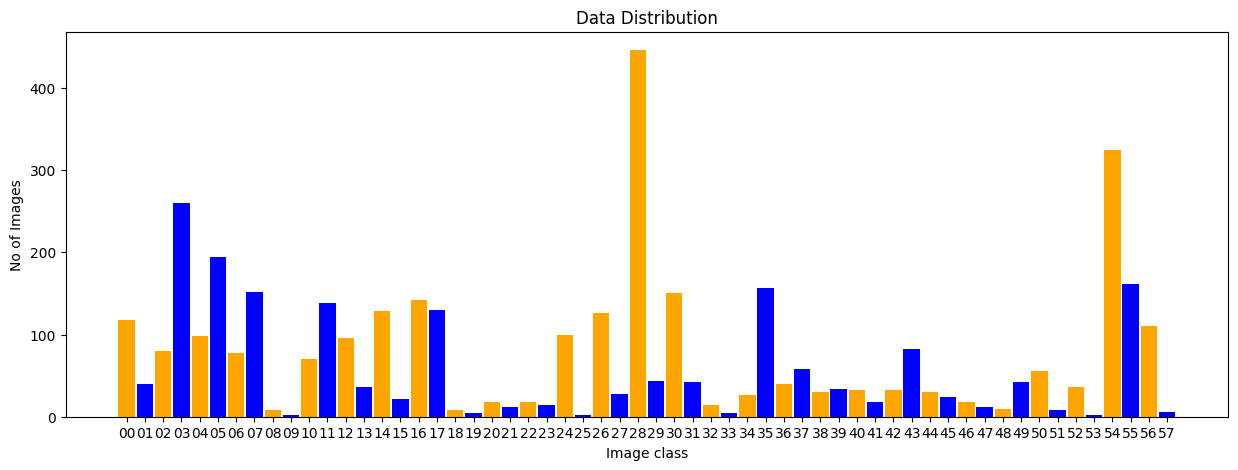

In [ ]:
def DataDistribution():
  for i in DATA_DIST.keys():
    folder_path = os.path.join(TRAIN_PATH, str(i))
    for file in os.listdir(folder_path):
      DATA_DIST[str(i)] += 1

    #print(DATA_DIST.values())
  plt.figure(figsize=(15, 5))
  plt.bar(DATA_DIST.keys(), DATA_DIST.values(),  color=["orange", "blue"], width=0.9)

  plt.xlabel("Image class")
  plt.ylabel("No of Images")
  plt.title("Data Distribution")
  plt.show()

DataDistribution()

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation((-0.2, 0.2), (-0.2, 0.2)),
    layers.RandomCrop(IMAGE_HEIGHT, IMAGE_WIDTH),
    layers.CenterCrop(IMAGE_HEIGHT, IMAGE_WIDTH),
])

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
     TRAIN_PATH,
     image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
     batch_size=BATCH_SIZE,
     validation_split=0.2,
     labels="inferred",
     label_mode="categorical",
     subset="training",
     seed=64 )

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    labels="inferred",
    label_mode="categorical",
    subset="validation",
    seed=64)
train_ds = train_ds.map(lambda x, y: (normalized_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalized_layer(x), y))

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))


Found 4170 files belonging to 58 classes.
Using 3336 files for training.
Found 4170 files belonging to 58 classes.
Using 834 files for validation.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(3000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

64


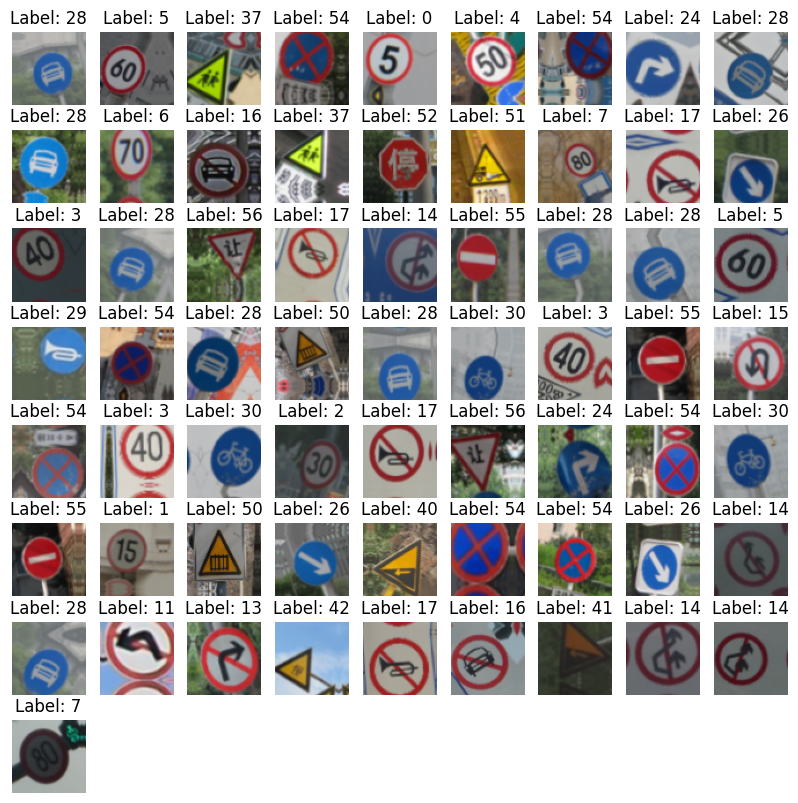

In [ ]:
for images, labels in train_ds.take(1):
    batch_size = images.shape[0]
    print(batch_size)
    plt.figure(figsize=(10, 10))
    for i in range(batch_size):
        ax = plt.subplot(int(batch_size**0.5), int(batch_size**0.5) + 1, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {np.argmax(labels[i].numpy())}")
        plt.axis("off")

    plt.show()

In [ ]:

def traffic_sign_cnn_model(train_directory_path):
  model = keras.Sequential([
      layers.InputLayer(input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3)),
      data_augmentation,
      layers.Conv2D(IMAGE_HEIGHT, (3,3), activation="relu"),
      layers.MaxPooling2D((2,2)),
      layers.BatchNormalization(),
      layers.Conv2D(256, (3,3), padding="same",  activation="relu"),
      layers.MaxPooling2D((2,2)),
      layers.BatchNormalization(),
      layers.Conv2D(512, (3,3), padding="same",  activation="relu"),
      layers.MaxPooling2D((2,2)),
      layers.Dropout(0.2),
      layers.Conv2D(1024, (5,5), padding="same", activation="relu"),
      layers.MaxPooling2D((2,2)),
      layers.BatchNormalization(),
      layers.Conv2D(2048, (5,5), padding="same",  activation="relu"),
      layers.MaxPooling2D((2,2)),
      layers.Dropout(0.4),
      layers.Flatten(),
      layers.Dense(1024, kernel_regularizer=regularizers.L2(l2=0.02),
                   bias_regularizer=regularizers.L1(l1=0.008),
                   activity_regularizer=regularizers.L1(l1=0.008), activation="relu",),

      layers.Dense(58, activation="softmax")
  ])
  print(model.summary())
  #callback = EarlyStopping(monitor="loss", min_delta=0.02, patience=5, restore_best_weights=True)
  optimizer = tf.keras.optimizers.Adam(0.001)
  model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics="accuracy")
  history = model.fit(train_ds, validation_data= val_ds, epochs=50, verbose=1)
  return model, history

In [ ]:
  model, history = traffic_sign_cnn_model(TRAIN_PATH)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 31, 31, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 256)       147712    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 256)      

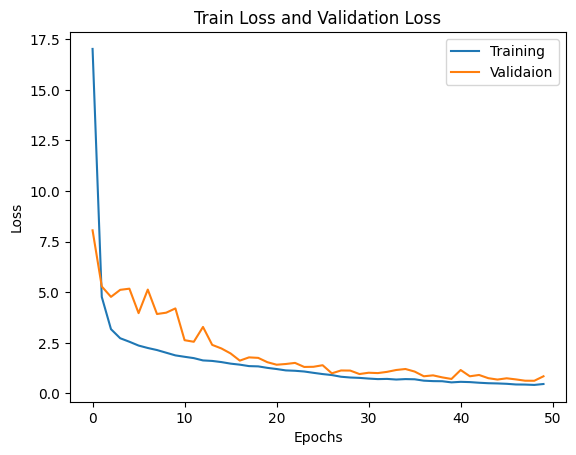

In [ ]:
train_loss = history.history['loss']
vali_loss = history.history['val_loss']
train_acc = history.history['accuracy']
vali_acc = history.history['val_accuracy']

plt.plot(train_loss)
plt.plot(vali_loss)
plt.title("Train Loss and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Training', 'Validaion'], loc="upper right")
plt.show()

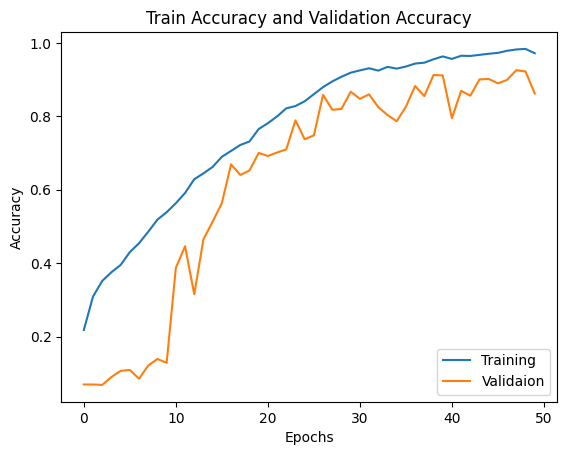

In [ ]:
plt.plot(train_acc)
plt.plot(vali_acc)
plt.title("Train Accuracy and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Training', 'Validaion'], loc="lower right")
plt.show()

In [ ]:
image_list = [TEST_PATH+"/"+file for file in os.listdir(TEST_PATH)]
labels = list(map(lambda path: int(os.path.split(os.path.split(path)[1])[1][1:3]), image_list))


In [ ]:
model.save("traffic_sign_model_75")

In [ ]:
!zip -r /content/traffic_sign_model_75.zip /content/traffic_sign_model_75



  adding: content/traffic_sign_model_75/ (stored 0%)
  adding: content/traffic_sign_model_75/assets/ (stored 0%)
  adding: content/traffic_sign_model_75/variables/ (stored 0%)
  adding: content/traffic_sign_model_75/variables/variables.index (deflated 70%)
  adding: content/traffic_sign_model_75/variables/variables.data-00000-of-00001 (deflated 25%)
  adding: content/traffic_sign_model_75/saved_model.pb (deflated 89%)
  adding: content/traffic_sign_model_75/fingerprint.pb (stored 0%)
  adding: content/traffic_sign_model_75/keras_metadata.pb (deflated 94%)


In [ ]:
new_labels = list(map(lambda num: one_hot_encode(num, 58), labels ))
new_labels = np.array(new_labels)


In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((image_list, new_labels))

In [ ]:
def process_path(file_path, label):
    # Load the raw data from the file as a string
    image = tf.io.read_file(file_path)
    # Decode the image into a dense vector
    image = tf.image.decode_png(image, channels=3)
    # Resize the image
    image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
    return image, label


In [ ]:
test_dataset = test_dataset.map(process_path)
test_dataset = test_dataset.map(lambda x, y: (normalized_layer(x), y))

In [ ]:
test_dataset = test_dataset.shuffle(buffer_size=1000)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
loss, acc = model.evaluate(test_dataset)
print("Loss: ", loss)
print("Accuracy: ", acc)

32/32 [==============================] - 3s 63ms/step - loss: 2.6110 - accuracy: 0.4534
Loss:  2.6110482215881348
Accuracy:  0.45336008071899414


64
2/2 [==============================] - 0s 58ms/step
(64, 58)


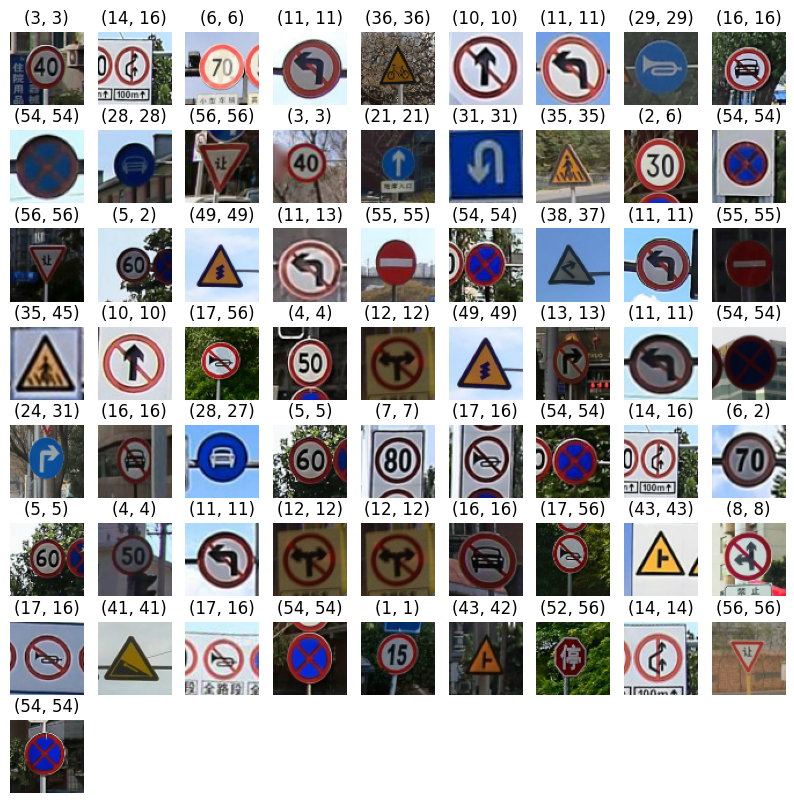

In [ ]:
data = test_dataset.take(1)
predictions = []
actual = []
for images, labels in data:
    batch_size = images.shape[0]
    print(batch_size)
    prediction = model.predict(images)
    plt.figure(figsize=(10, 10))
    print(prediction.shape)
    for i in range(batch_size):
        ax = plt.subplot(int(batch_size**0.5), int(batch_size**0.5) + 1, i + 1)
        plt.imshow(images[i])
        plt.title(f"{np.argmax(labels[i].numpy()), np.argmax(prediction[i])}")
        plt.axis("off")
        predictions.append(np.argmax(prediction[i]))
        actual.append(np.argmax(labels[i].numpy()))

    plt.show()

In [ ]:
result = confusion_matrix(actual, predictions, normalize="pred")

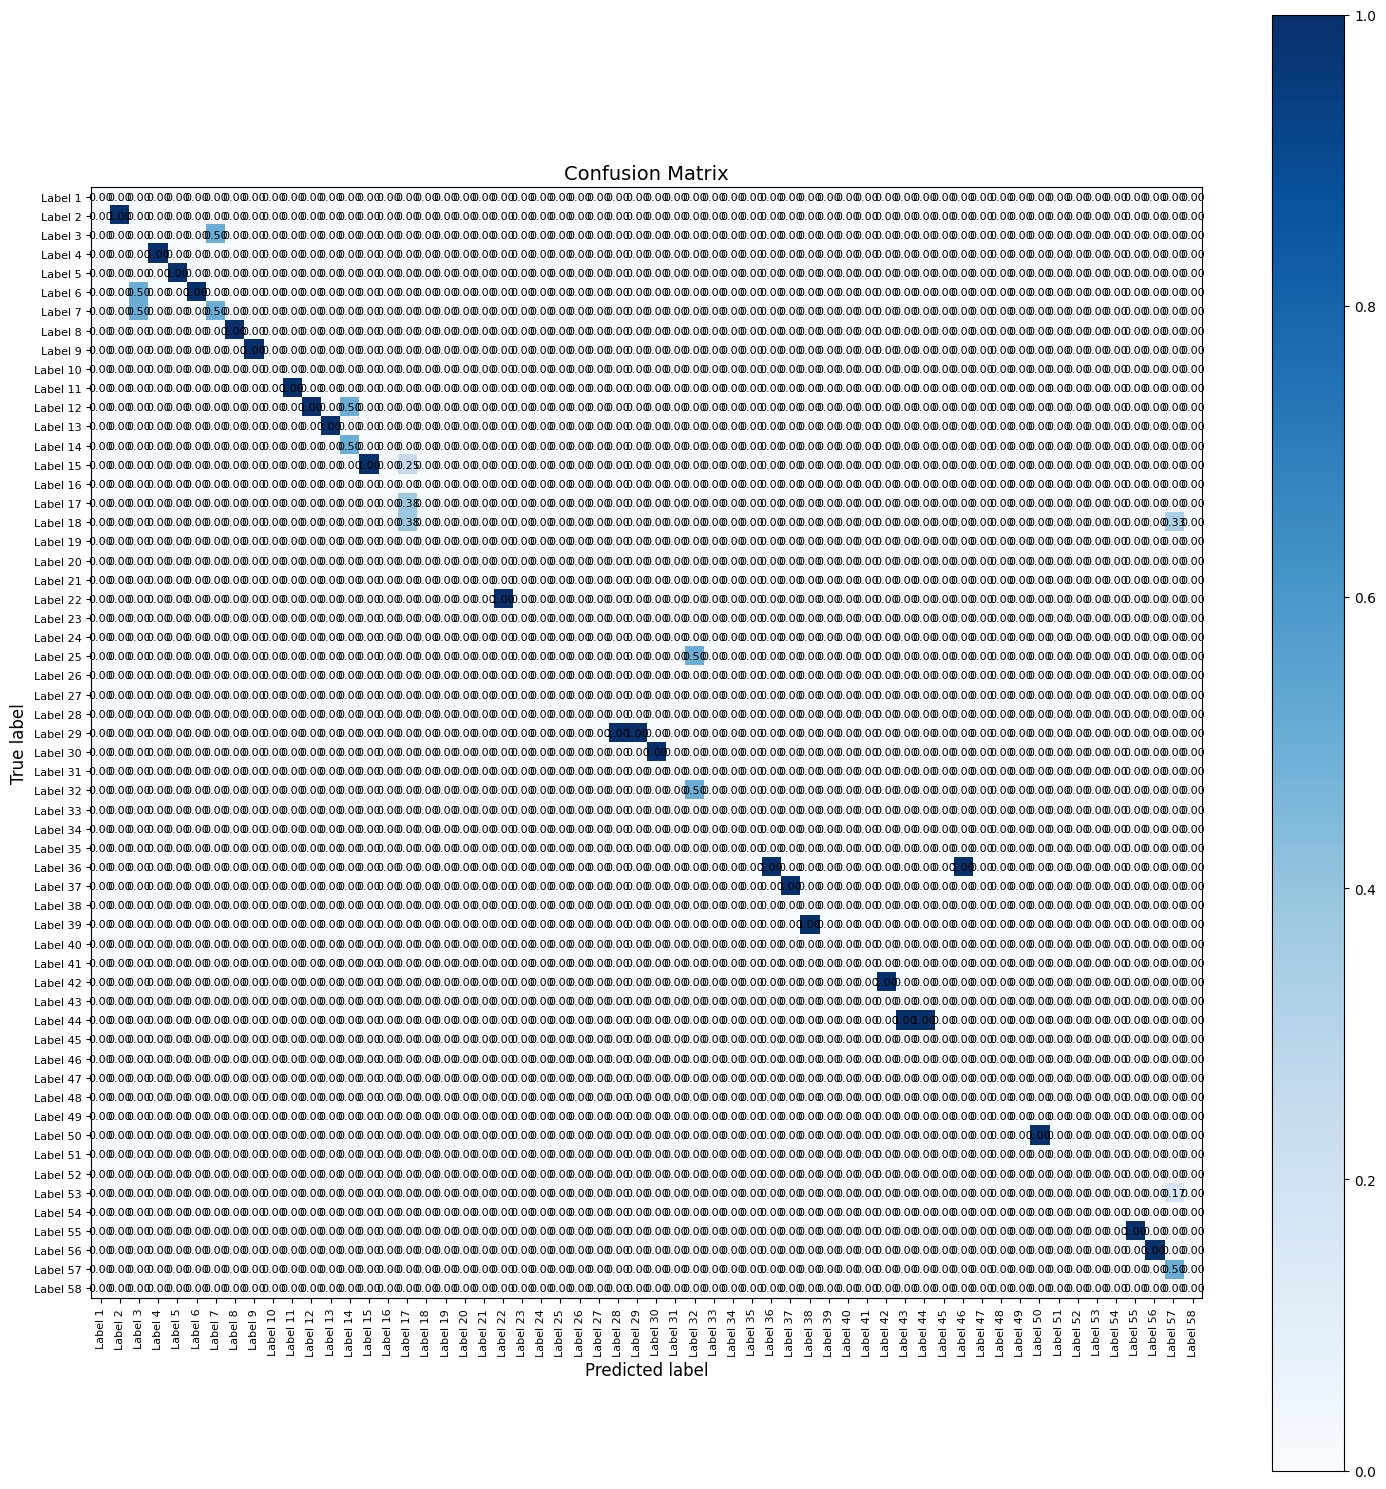

In [ ]:
from sklearn.metrics import confusion_matrix

# Assuming actual and predictions are your data
all_classes = list(range(58))  # Adjust this if your class labels are different
result = confusion_matrix(actual, predictions, labels=all_classes, normalize="pred")

# Plotting the confusion matrix
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(15, 15))  # Adjusted figure size for 58x58 matrix
im = ax.imshow(result, cmap=plt.cm.Blues)
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_xlabel('Predicted label', fontsize=12)
ax.set_ylabel('True label', fontsize=12)

# Adjust the labels for a 58x58 matrix
labels = [f'Label {i}' for i in range(1, 59)]

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=90, fontsize=8)
ax.set_yticklabels(labels, fontsize=8)

for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, f'{result[i, j]:.2f}',
                       ha="center", va="center", color="black", fontsize=8)

ax.set_title("Confusion Matrix", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
!zip -r traffic_sign_model_75 /traffic_sign_model_75


  adding: traffic_sign_model_75/ (stored 0%)
  adding: traffic_sign_model_75/assets/ (stored 0%)
  adding: traffic_sign_model_75/variables/ (stored 0%)
  adding: traffic_sign_model_75/variables/variables.index (deflated 70%)
  adding: traffic_sign_model_75/variables/variables.data-00000-of-00001 (deflated 25%)
  adding: traffic_sign_model_75/saved_model.pb (deflated 89%)
  adding: traffic_sign_model_75/fingerprint.pb (stored 0%)
  adding: traffic_sign_model_75/keras_metadata.pb (deflated 94%)
